<a href="https://colab.research.google.com/github/apiasak/datascience-portfolio/blob/main/code/Pycaret/Time_series_Sales_Forecast_using_PyCaret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales forecast with PyCaret พยากรณ์ยอดขายด้วย PyCaret

## PyCaret คืออะไร?

PyCaret คือ Machine Learning Library ที่สามารถนำมาใช้กับภาษา Python มีคุณสมบัติช่วยให้เราสามารถและ Train Machine Learning โมเดล ได้อย่างรวดเร็วและง่ายดาย PyCaret 
ถือว่าเป็น low-code machine learning library ที่ช่วยให้การสร้าง Machine Learning model สามารถทำได้ในไม่กี่ขั้นตอน ย่อโค้ดจากโค้ดหลายร้อยบรรทัดให้เหลือเพียงไม่กี่บรรทัดได้อยางรวดเร็ว วันนี้เราจะมาลองใช้งานกันดูครับ

## ขั้นตอนที่ 1: ติดตั้ง Pycaret และโหลดข้อมูล

PyCaret สามารถติดตั้งได้โดยใช้ pip package manager ในการติดตั้ง PyCaret เพียงพิมพ์คำสั่งต่อไปนี้ 

`pip install --pre pycaret`

In [ ]:
# Install pycaret
!pip install --pre pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import Library

Import Library ที่จำเป็นในการใช้งาน

In [ ]:
import pandas as pd
import numpy as np

from datetime import datetime

import plotly.express as px
import plotly.graph_objects as go

### Load data
นำเข้าข้อมูล โดย PyCaret สามารถใช้งานร่วมกับ Pandas DataFrame ได้ โดยเราจะใช้ข้อมูล Online Retail จาก UCI นะครับ

In [ ]:
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')

In [ ]:
# Calculate Sales Revenue
df['Revenue'] = round(df['Quantity'] * df['UnitPrice'], 2)

In [ ]:
# Convert date
df['Date'] = pd.to_datetime(df['InvoiceDate'].dt.date)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
 8   Revenue      541909 non-null  float64       
 9   Date         541909 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1), object(4)
memory usage: 41.3+ MB


In [ ]:
min(df['Date']), max(df['Date'])

(Timestamp('2010-12-01 00:00:00'), Timestamp('2011-12-09 00:00:00'))

In [ ]:
# Group by aggreate สรุปยอดขายในแต่ละวัน
revenue_df = df[['Date','Revenue']].groupby('Date').sum().reset_index()

In [ ]:
revenue_df.head()

,Date,Revenue
0,2010-12-01,58635.56
1,2010-12-02,46207.28
2,2010-12-03,45620.46
3,2010-12-05,31383.95
4,2010-12-06,53860.18


In [ ]:
revenue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     305 non-null    datetime64[ns]
 1   Revenue  305 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.9 KB


### Explore the data

In [ ]:
# create 12 month moving average
revenue_df['MA12'] = revenue_df['Revenue'].rolling(12).mean()

In [ ]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=revenue_df['Date'], y=revenue_df['Revenue'],
                    mode='lines+markers',
                    name='Revenue'))
fig.add_trace(go.Scatter(x=revenue_df['Date'], y=revenue_df['MA12'],
                    mode='lines+markers',
                    name='MA12'))

fig.show()

In [ ]:
px.scatter(revenue_df, x= 'Date', y = 'Revenue', trendline = "ols")

## ขั้นตอนที่ 2: เตรียมข้อมูลและการ Train model
สร้างข้อมูลเพื่อใช้ในการ Train model โดยสร้างจาก วันที่ เดือน ไตรมาส วันทำการ สัปดาห์ เพื่อใช้ในการทำ Forecast

In [ ]:
revenue_df['Dateofmonth'] = revenue_df['Date'].dt.day
revenue_df['Month'] = revenue_df['Date'].dt.month
revenue_df['Week'] = revenue_df['Date'].dt.week
revenue_df['Dayofweek'] = revenue_df['Date'].dt.dayofweek # 0 = monday.
revenue_df['Weekdayflg'] = (revenue_df['Dayofweek'] // 5 != 1).astype(float)
revenue_df['Month'] = revenue_df['Date'].dt.month
revenue_df['Quarter'] = revenue_df['Date'].dt.quarter
revenue_df['Dayofyear'] = revenue_df['Date'].dt.dayofyear
revenue_df['Year'] = revenue_df['Date'].dt.year
# create a sequence of numbers
revenue_df['time_series'] = np.arange(1,len(revenue_df)+1)

In [ ]:
# check the head of the dataset
revenue_df.tail()

,Date,Revenue,MA12,Dateofmonth,Month,Week,Dayofweek,Weekdayflg,Quarter,Dayofyear,Year,time_series
300,2011-12-05,57751.32,53125.735833,5,12,49,0,1.0,4,339,2011,301
301,2011-12-06,54228.37,52452.490000,6,12,49,1,1.0,4,340,2011,302
302,2011-12-07,75076.22,52168.783333,7,12,49,2,1.0,4,341,2011,303
303,2011-12-08,81417.78,54946.908333,8,12,49,3,1.0,4,342,2011,304
304,2011-12-09,32131.53,53420.975833,9,12,49,4,1.0,4,343,2011,305


In [ ]:
# Drop ข้อมูลที่ไม่ต้องการ
data = revenue_df.drop(['Date', 'MA12'], axis=True)

In [ ]:
data.tail()

,Revenue,Dateofmonth,Month,Week,Dayofweek,Weekdayflg,Quarter,Dayofyear,Year,time_series
300,57751.32,5,12,49,0,1.0,4,339,2011,301
301,54228.37,6,12,49,1,1.0,4,340,2011,302
302,75076.22,7,12,49,2,1.0,4,341,2011,303
303,81417.78,8,12,49,3,1.0,4,342,2011,304
304,32131.53,9,12,49,4,1.0,4,343,2011,305


### สร้าง Train, Test dataset
สร้าง Train, test data set โดยใช้หลักการ 70/30 

In [ ]:
data['time_series'].nunique()*0.7

213.5

In [ ]:
# split data into train-test set
train = data[data['time_series'] < 213]
test = data[data['time_series'] >= 213]

# check shape
train.shape, test.shape

((212, 10), (93, 10))

### Import PyCaret Module

In [ ]:
# import the regression module
from pycaret.regression import *

### Train the model
Train model จากข้อมูล Test dataset

In [ ]:
session_1 = setup(train, target = 'Revenue', 
                  session_id=123, log_experiment=False, 
                  experiment_name='Revenue_1')

,Description,Value
0,session_id,123
1,Target,Revenue
2,Original Data,"(212, 10)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(148, 19)"


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=['time_series'],
                                      ml_usecase='regression',
                                      numerical_features=[], target='Revenue',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                num...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluste

In [ ]:
best_model = compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,7406.2039,1.116617e+08,10226.1934,0.3075,0.4057,0.3601,0.043
gbr,Gradient Boosting Regressor,7445.4890,1.042049e+08,10025.9015,0.3269,0.4225,0.3864,0.046
rf,Random Forest Regressor,7594.9151,1.092196e+08,10292.2591,0.2979,0.4209,0.3842,0.405
ridge,Ridge Regression,7745.6760,1.098656e+08,10144.2909,0.3169,0.4140,0.3856,0.014
llar,Lasso Least Angle Regression,7775.7608,1.105913e+08,10182.5351,0.3112,0.4160,0.3821,0.015
lasso,Lasso Regression,7779.5548,1.106917e+08,10187.1625,0.3104,0.4163,0.3821,0.016
lr,Linear Regression,7781.1350,1.107209e+08,10188.6905,0.3102,0.4164,0.3821,0.014
lar,Least Angle Regression,7817.2416,1.113188e+08,10209.5201,0.3085,0.4179,0.3841,0.017
lightgbm,Light Gradient Boosting Machine,7901.6795,1.111780e+08,10310.2361,0.3063,0.4412,0.4199,0.023
et,Extra Trees Regressor,7965.5975,1.143596e+08,10489.2032,0.2512,0.4584,0.4006,0.396


INFO:logs:create_model_container: 36
INFO:logs:master_model_container: 36
INFO:logs:display_container: 3
INFO:logs:HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


In [ ]:
model_metadata = models()
model_metadata['Name'] # with ids

INFO:logs:gpu_param set to False


ID
lr                          Linear Regression
lasso                        Lasso Regression
ridge                        Ridge Regression
en                                Elastic Net
lar                    Least Angle Regression
llar             Lasso Least Angle Regression
omp               Orthogonal Matching Pursuit
br                             Bayesian Ridge
ard         Automatic Relevance Determination
par              Passive Aggressive Regressor
ransac                Random Sample Consensus
tr                         TheilSen Regressor
huber                         Huber Regressor
kr                               Kernel Ridge
svm                 Support Vector Regression
knn                     K Neighbors Regressor
dt                    Decision Tree Regressor
rf                    Random Forest Regressor
et                      Extra Trees Regressor
ada                        AdaBoost Regressor
gbr               Gradient Boosting Regressor
mlp                            

### Parameter Tuning
Create a Model
The function that actually allows you to create a model is called create_model()

Model currently under consideration:

1.   huber
2.   gbr
3.   rf



In [ ]:
huber  = create_model('huber')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7268.8946,8.693659e+07,9323.9795,0.4530,0.3854,0.3385
1,4881.7854,3.857067e+07,6210.5293,0.7946,0.3195,0.2353
2,9755.8056,1.475002e+08,12144.9661,-0.0979,0.4350,0.3293
3,5862.9148,6.636219e+07,8146.2992,0.2929,0.3437,0.2760
4,8404.2337,1.425140e+08,11937.9218,0.4029,0.4558,0.4300
5,9159.2263,1.725724e+08,13136.6797,-0.1842,0.5818,0.6573
6,7183.5360,8.671617e+07,9312.1517,0.1584,0.4890,0.4791
7,6497.0251,1.478706e+08,12160.2041,0.2018,0.3284,0.2200
8,10148.9852,1.905394e+08,13803.5996,0.3313,0.4960,0.4562


INFO:logs:create_model_container: 37
INFO:logs:master_model_container: 37
INFO:logs:display_container: 4
INFO:logs:HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [ ]:
gbr  = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8285.0985,9.667855e+07,9832.5249,0.3917,0.3969,0.3774
1,7526.0891,1.232529e+08,11101.9324,0.3435,0.4998,0.5142
2,8657.9942,1.386467e+08,11774.8315,-0.0320,0.4061,0.2709
3,5806.2993,5.981820e+07,7734.2229,0.3626,0.3208,0.2622
4,5422.6085,4.658340e+07,6825.2036,0.8048,0.4073,0.3868
5,9561.2245,1.648259e+08,12838.4557,-0.1311,0.5710,0.6482
6,7174.1099,7.196861e+07,8483.4313,0.3015,0.4481,0.4153
7,7388.3461,1.464508e+08,12101.6857,0.2095,0.3523,0.2879
8,8541.4144,1.183268e+08,10877.8125,0.5848,0.4938,0.4587


INFO:logs:create_model_container: 39
INFO:logs:master_model_container: 39
INFO:logs:display_container: 6
INFO:logs:GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=123, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [ ]:
rf  = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7246.2293,7.773330e+07,8816.6492,0.5109,0.3744,0.3430
1,6300.6346,8.283050e+07,9101.1265,0.5588,0.4052,0.3774
2,8639.0822,1.207125e+08,10986.9223,0.1015,0.3759,0.2913
3,6442.9372,7.717398e+07,8784.8720,0.1777,0.3871,0.2979
4,7074.1674,9.276961e+07,9631.6982,0.6113,0.4191,0.3795
5,10462.7966,1.949495e+08,13962.4311,-0.3378,0.5997,0.7194
6,7215.2110,7.482271e+07,8650.0123,0.2738,0.4721,0.4548
7,7662.6596,1.634107e+08,12783.2182,0.1180,0.3619,0.2852
8,8416.8330,1.312283e+08,11455.4905,0.5395,0.4763,0.4293


INFO:logs:create_model_container: 40
INFO:logs:master_model_container: 40
INFO:logs:display_container: 7
INFO:logs:RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [ ]:
tuned_huber = tune_model(huber)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7320.0948,8.975426e+07,9473.8724,0.4353,0.3866,0.3405
1,5028.6086,4.105176e+07,6407.1649,0.7813,0.3349,0.2430
2,9849.5133,1.485694e+08,12188.9029,-0.1058,0.4360,0.3323
3,5786.2278,6.612662e+07,8131.8279,0.2954,0.3461,0.2765
4,8198.8333,1.317967e+08,11480.2723,0.4478,0.4475,0.4232
5,9239.4119,1.676668e+08,12948.6226,-0.1506,0.5777,0.6530
6,7133.1339,8.032634e+07,8962.4963,0.2204,0.4779,0.4727
7,6845.9385,1.525060e+08,12349.3314,0.1768,0.3400,0.2399
8,10418.3234,1.903441e+08,13796.5234,0.3320,0.5024,0.4722


INFO:logs:create_model_container: 41
INFO:logs:master_model_container: 41
INFO:logs:display_container: 8
INFO:logs:HuberRegressor(alpha=1e-07, epsilon=1.6, fit_intercept=False, max_iter=100,
               tol=1e-05, warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [ ]:
tuned_gbr = tune_model(gbr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8297.4909,1.089347e+08,10437.1779,0.3146,0.4259,0.4076
1,7652.5593,7.630931e+07,8735.5199,0.5935,0.4875,0.5181
2,8835.9393,1.275951e+08,11295.7990,0.0503,0.3454,0.2808
3,5746.5712,6.380883e+07,7988.0427,0.3201,0.4013,0.3552
4,9266.1430,1.263870e+08,11242.1993,0.4705,0.5471,0.6041
5,8581.7993,1.272986e+08,11282.6682,0.1264,0.5183,0.5308
6,7197.7942,8.336351e+07,9130.3621,0.1909,0.5059,0.4976
7,7938.4655,1.702001e+08,13046.0768,0.0813,0.3948,0.3157
8,10644.8159,1.888291e+08,13741.5112,0.3374,0.5947,0.6390


INFO:logs:create_model_container: 42
INFO:logs:master_model_container: 42
INFO:logs:display_container: 9
INFO:logs:GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=7,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.05, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=140,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=123, subsample=0.35, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [ ]:
tuned_rf = tune_model(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7661.6212,9.153294e+07,9567.2848,0.4241,0.4001,0.3696
1,6347.8143,5.661321e+07,7524.1751,0.6985,0.4003,0.4020
2,9054.3063,1.293271e+08,11372.2052,0.0374,0.3682,0.2955
3,5787.8088,6.395752e+07,7997.3444,0.3185,0.3447,0.2947
4,7530.4122,8.826585e+07,9394.9905,0.6302,0.4429,0.4490
5,8872.3198,1.411707e+08,11881.5275,0.0313,0.5460,0.5933
6,7322.8562,8.048511e+07,8971.3494,0.2188,0.4877,0.4705
7,7201.9655,1.580280e+08,12570.9177,0.1470,0.3684,0.2800
8,8720.8991,1.162041e+08,10779.8002,0.5922,0.5013,0.5024


INFO:logs:create_model_container: 43
INFO:logs:master_model_container: 43
INFO:logs:display_container: 10
INFO:logs:RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0001,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=240, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


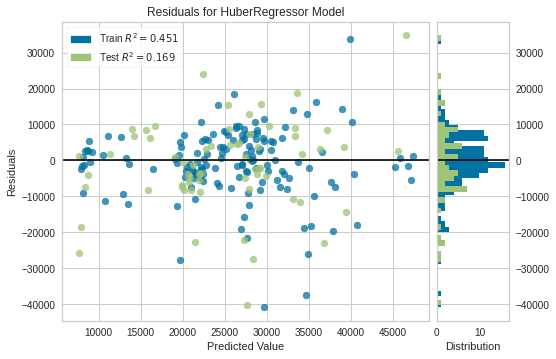

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_huber)

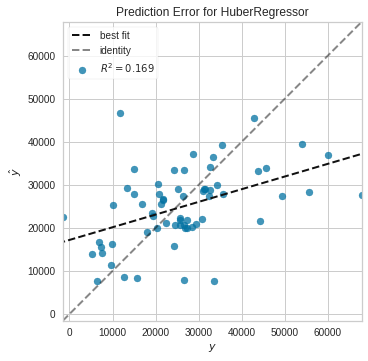

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_huber, plot = 'error')

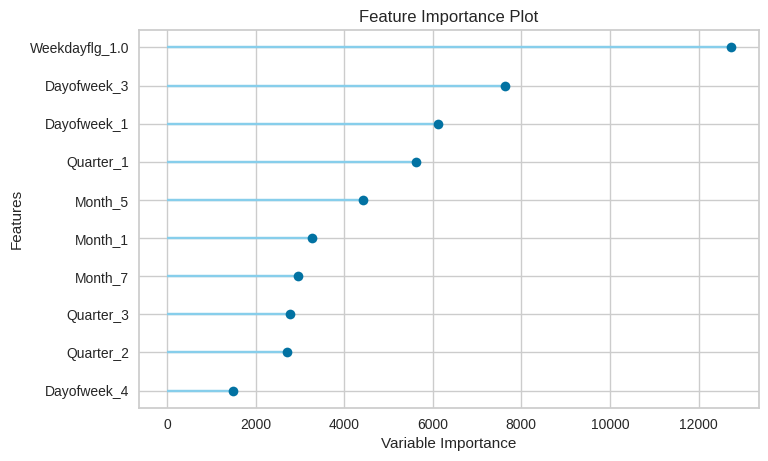

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_huber, plot='feature')

In [ ]:
evaluate_model(tuned_huber)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=HuberRegressor(alpha=1e-07, epsilon=1.6, fit_intercept=False, max_iter=100,
               tol=1e-05, warm_start=False), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
blend = blend_models(estimator_list = [tuned_huber, tuned_gbr, tuned_rf])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7647.1719,9.313864e+07,9650.8362,0.4140,0.3922,0.3616
1,6259.3780,5.004650e+07,7074.3553,0.7334,0.3771,0.3790
2,9177.5948,1.289374e+08,11355.0615,0.0403,0.3724,0.3013
3,5607.9537,6.226731e+07,7890.9639,0.3365,0.3557,0.3014
4,8279.3036,1.123060e+08,10597.4519,0.5295,0.4790,0.4904
5,8305.3490,1.389058e+08,11785.8321,0.0468,0.5430,0.5717
6,7084.0431,7.887578e+07,8881.2038,0.2345,0.4886,0.4762
7,7270.8802,1.577959e+08,12561.6820,0.1483,0.3609,0.2751
8,9928.0128,1.584702e+08,12588.4961,0.4439,0.5261,0.5378


INFO:logs:create_model_container: 44
INFO:logs:master_model_container: 44
INFO:logs:display_container: 11
INFO:logs:VotingRegressor(estimators=[('huber',
                             HuberRegressor(alpha=1e-07, epsilon=1.6,
                                            fit_intercept=False, max_iter=100,
                                            tol=1e-05, warm_start=False)),
                            ('gbr',
                             GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.01,
                                                       loss='ls', max_depth=7,
                                                       max_features='sqrt',
                                                       max_leaf_nodes=None,
                                                    

In [ ]:
final_blend = finalize_model(blend)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=VotingRegressor(estimators=[('huber',
                             HuberRegressor(alpha=1e-07, epsilon=1.6,
                                            fit_intercept=False, max_iter=100,
                                            tol=1e-05, warm_start=False)),
                            ('gbr',
                             GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.01,
                                                       loss='ls', max_depth=7,
                                                       max_features='sqrt',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.05,
          

In [ ]:
pred = predict_model(blend);

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=VotingRegressor(estimators=[('huber',
                             HuberRegressor(alpha=1e-07, epsilon=1.6,
                                            fit_intercept=False, max_iter=100,
                                            tol=1e-05, warm_start=False)),
                            ('ridge',
                             Ridge(alpha=2.81, copy_X=True, fit_intercept=False,
                                   max_iter=None, normalize=True,
                                   random_state=123, solver='auto',
                                   tol=0.001)),
                            ('lar',
                             LassoLars(alpha=1.0, copy_X=True, eps=0.02,
                                       fit_intercept=True, fit_path=True,
                                       jitter=None, max_iter=500,
                                       normalize=True, positive=False,
                                       preco

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,10075.2377,2.042393e+08,14291.2329,0.4748,0.5545,0.563


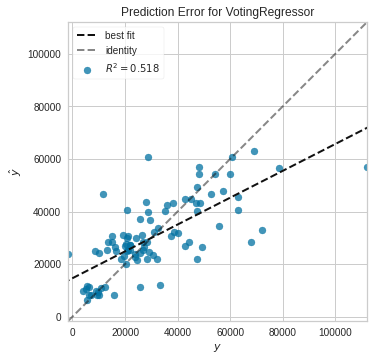

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(final_blend, plot = 'error')

## ขั้นตอนที่ 3: Predict data

นำ Model ที่ได้มา predict  ข้อมูล Test dataset

In [ ]:
# generate predictions on the original dataset
predictions = predict_model(final_blend, data=data)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=VotingRegressor(estimators=[('huber',
                             HuberRegressor(alpha=1e-07, epsilon=1.6,
                                            fit_intercept=False, max_iter=100,
                                            tol=1e-05, warm_start=False)),
                            ('gbr',
                             GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.01,
                                                       loss='ls', max_depth=7,
                                                       max_features='sqrt',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.05,
            

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,8812.3666,1.735626e+08,13174.3149,0.4258,0.4087,0.3574


In [ ]:
# add a date column in the dataset
predictions['Date'] = pd.to_datetime(dict(year=predictions['Year'], month=predictions['Month'], day=predictions['Dateofmonth']))

In [ ]:
# line plot
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=predictions['Date'], y=predictions['Revenue'],
                    mode='lines+markers',
                    name='Revenue'))
fig.add_trace(go.Scatter(x=predictions['Date'], y=predictions['Label'],
                    mode='lines+markers',
                    name='Predict'))

#fig.show()

#fig = px.line(predictions, x='Date', y=["Revenue", "Label"], )
fig.add_vrect(x0="2011-08-22", x1="2011-12-09", fillcolor="red", opacity=0.10, line_width=0)
fig.show()

## ขั้นตอนที่ 4: Predict ข้อมูลในอนาคต

นำ model มา predict ข้อมูลในอนาคต

In [ ]:
future_dates = pd.date_range(start = '2011-12-10', end = '2012-03-31', freq='D')
future_df = pd.DataFrame(future_dates, columns=['Date'])
future_df['Dateofmonth'] = future_df['Date'].dt.day
future_df['Month'] = future_df['Date'].dt.month
future_df['Week'] = future_df['Date'].dt.week
future_df['Dayofweek'] = future_df['Date'].dt.dayofweek # 0 = monday.
future_df['Weekdayflg'] = (future_df['Dayofweek'] // 5 != 1).astype(float)
future_df['Month'] = future_df['Date'].dt.month
future_df['Quarter'] = future_df['Date'].dt.quarter
future_df['Dayofyear'] = future_df['Date'].dt.dayofyear
future_df['Year'] = future_df['Date'].dt.year
# create a sequence of numbers
future_df['time_series'] = np.arange(305,(305+len(future_dates)))
future_df.head()

,Date,Dateofmonth,Month,Week,Dayofweek,Weekdayflg,Quarter,Dayofyear,Year,time_series
0,2011-12-10,10,12,49,5,0.0,4,344,2011,305
1,2011-12-11,11,12,49,6,0.0,4,345,2011,306
2,2011-12-12,12,12,50,0,1.0,4,346,2011,307
3,2011-12-13,13,12,50,1,1.0,4,347,2011,308
4,2011-12-14,14,12,50,2,1.0,4,348,2011,309


In [ ]:
predictions_future = predict_model(final_blend, data=future_df)
predictions_future.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=VotingRegressor(estimators=[('huber',
                             HuberRegressor(alpha=1e-07, epsilon=1.6,
                                            fit_intercept=False, max_iter=100,
                                            tol=1e-05, warm_start=False)),
                            ('gbr',
                             GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.01,
                                                       loss='ls', max_depth=7,
                                                       max_features='sqrt',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.05,
            

,Date,Dateofmonth,Month,Week,Dayofweek,Weekdayflg,Quarter,Dayofyear,Year,time_series,Label
0,2011-12-10,10,12,49,5,0.0,4,344,2011,305,25080.180641
1,2011-12-11,11,12,49,6,0.0,4,345,2011,306,24142.090081
2,2011-12-12,12,12,50,0,1.0,4,346,2011,307,36368.826790
3,2011-12-13,13,12,50,1,1.0,4,347,2011,308,41112.483863
4,2011-12-14,14,12,50,2,1.0,4,348,2011,309,35695.388724


In [ ]:
concat_df = pd.concat([data,predictions_future], axis=0)
concat_df_i = pd.to_datetime(dict(year=concat_df['Year'], month=concat_df['Month'], day=concat_df['Dateofmonth']))
concat_df.set_index(concat_df_i, inplace=True)
# fig = px.line(concat_df, x=concat_df.index, y=["Revenue", "Label"], template = 'plotly_dark')
# fig.show()


# line plot
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=concat_df.index, y=concat_df['Revenue'],
                    mode='lines+markers',
                    name='Revenue'))
fig.add_trace(go.Scatter(x=concat_df.index, y=concat_df['Label'],
                    mode='lines+markers',
                    name='Predict'))

#fig = px.line(predictions, x='Date', y=["Revenue", "Label"], )
fig.add_vrect(x0="2011-12-10", x1="2012-03-31", fillcolor="red", opacity=0.10, line_width=0)
fig.show()

## บทสรุป
โดยสรุป การใช้ PyCaret สำหรับการคาดการณ์ยอดขายสามารถเป็นเครื่องมือที่มีประโยชน์ ที่ีรวบรวม Library และ Algorithm ของ Machine Learning มาช่วยสร้าง model และ เทียบ output ได้ง่าย สามารถลดโค้ดในการเขียนโปรแกรมลงได้เยอะ
แม้ว่าผลลัพธ์ของ PyCaret อาจจะยังไม่สมบูรณ์แบบ แต่ก็เหมาะกับโครงการที่ต้องการความรวดเร็วในการวิเคราะห์ เพื่อหา Key trend คร่าวๆ ของข้อมูลได้